### IMPORTAR LIBRERÍAS

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import sys

from sklearn.svm import SVC
from datetime import time
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

### <CENTER> **PLAN DE TRABAJO** </CENTER>

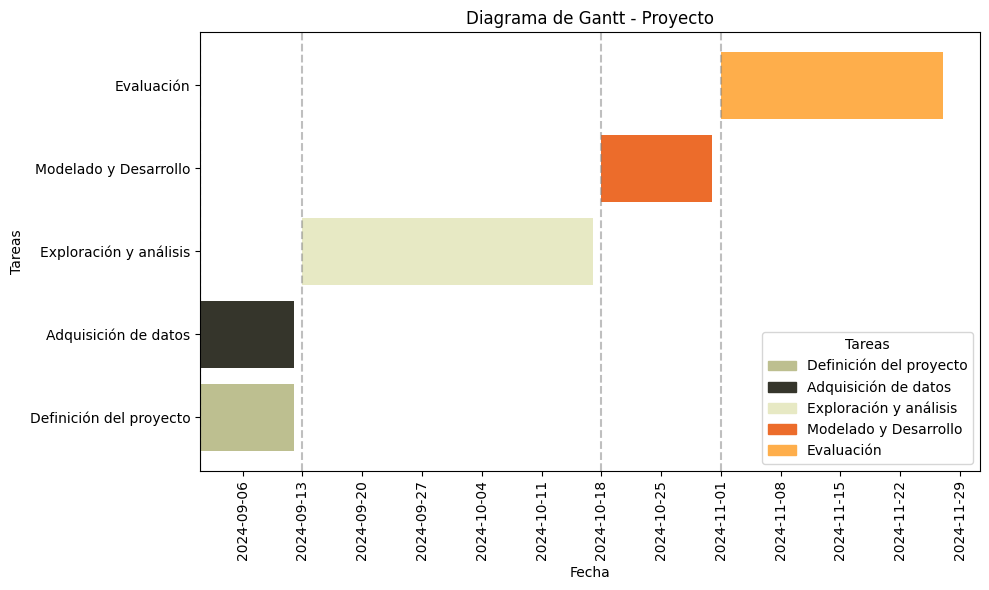

In [2]:
# Datos de ejemplo
data = {
    'Tarea': ['Definición del proyecto', 'Adquisición de datos', 'Exploración y análisis', 'Modelado y Desarrollo', 'Evaluación'],
    'Inicio': ['2024-09-01', '2024-09-01', '2024-09-13', '2024-10-18', '2024-11-01'],
    'Fin': ['2024-09-12', '2024-09-12', '2024-10-17', '2024-10-31', '2024-11-27'],
    'Color': ['#bdbf90', '#35352b', '#e7e9c4', '#ec6c2b', '#feae4b']  # Colores personalizados para cada tarea
}

# Convertir a DataFrame
df = pd.DataFrame(data)
df['Inicio'] = pd.to_datetime(df['Inicio'])
df['Fin'] = pd.to_datetime(df['Fin'])

# Calcular duración de cada tarea
df['Duración'] = (df['Fin'] - df['Inicio']).dt.days

# Crear un diagrama de Gantt
fig, ax = plt.subplots(figsize=(10, 6))

# Crear barras del diagrama de Gantt con colores personalizados
for i, row in df.iterrows():
    ax.barh(row['Tarea'], row['Duración'], left=row['Inicio'], color=row['Color'])

# Formatear el eje x para que se muestren las fechas de forma adecuada
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))  # Mostrar fechas cada 7 días
plt.xticks(rotation=90)

# Añadir etiquetas y título
plt.xlabel('Fecha')
plt.ylabel('Tareas')
plt.title('Diagrama de Gantt - Proyecto')

# Añadir leyenda personalizada con colores de tareas
patches = [mpatches.Patch(color=color, label=task) for task, color in zip(df['Tarea'], df['Color'])]
plt.legend(handles=patches, title='Tareas')

# Añadir líneas de tiempo verticales
for i in range(len(df)):
    plt.axvline(df['Inicio'][i], color='grey', linestyle='--', alpha=0.5)

# Mostrar gráfico
plt.tight_layout()
plt.show()



### <CENTER> **LECTURA DE DATOS** </CENTER>

In [3]:
data = pd.read_excel("Activities.xlsx")

Min Elevation y Max Elevation a veces no tienen mediciones al ser corridas en máquina, por ende estos datos deben ser imputados.

### <CENTER> **PREPROCESAMIENTO DE DATOS** </CENTER>

In [4]:
data['Best Pace'] = data['Best Pace'].astype(str).str[:-3]
data['Avg Pace'] = data['Avg Pace'].astype(str).str[:-3]
data['Avg GAP'] = data['Avg GAP'].astype(str).str[:-3]

In [5]:
#Separo mis columnas de tiempo
Time_columns = ['Time', 'Best Lap Time', 'Moving Time', 'Elapsed Time']
Pace_columns = ['Avg Pace', 'Best Pace', 'Avg GAP']

In [6]:
#Función para convertir columnas a formato timedelta
def convert_to_timedelta(column):
    """
    Convierte una columna de pandas en formato timedelta.
    
    Parameters:
    column (pd.Series): La columna a convertir.

    Returns:
    pd.Series: La columna convertida a timedelta.
    """
    # Reemplazar '--' con NaT (Not a Time)
    column = column.replace('--', pd.NaT)

    # Convertir los objetos datetime.time a cadenas en formato 'hh:mm:ss'
    column = column.apply(lambda x: x.strftime('%H:%M:%S') if isinstance(x, time) else x)

    # Convertir a timedelta
    return pd.to_timedelta(column)

#Función para convertir columnas a formato timedelta
def timedelta_pace_columns(column):
    """
    Convierte una columna de pandas en formato timedelta.
    
    Parameters:
    column (pd.Series): La columna a convertir.

    Returns:
    pd.Series: La columna convertida a timedelta.
    """
    # Reemplazar '--' con NaT (Not a Time)
    column = column.replace('--', pd.NaT)

 # Convertir los objetos en formato 'mm:ss:ms' a formato adecuado para timedelta
    column = column.apply(lambda x: f"00:{x}" if isinstance(x, str) and ':' in x else x)


    # Convertir a timedelta
    return pd.to_timedelta(column)

In [7]:
# Convertir las columnas de tiempo a timedelta

for col in Time_columns:
    data[col] = convert_to_timedelta(data[col])

for col in Pace_columns:
    data[col] = timedelta_pace_columns(data[col])

In [8]:
#Verifico que hayan cambiado
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 29 columns):
 #   Column                     Non-Null Count  Dtype          
---  ------                     --------------  -----          
 0   Distance                   303 non-null    float64        
 1   Calories                   303 non-null    float64        
 2   Time                       303 non-null    timedelta64[ns]
 3   Avg HR                     303 non-null    int64          
 4   Max HR                     303 non-null    int64          
 5   Aerobic TE                 303 non-null    float64        
 6   Avg Run Cadence            303 non-null    int64          
 7   Max Run Cadence            303 non-null    int64          
 8   Avg Pace                   303 non-null    timedelta64[ns]
 9   Best Pace                  303 non-null    timedelta64[ns]
 10  Total Ascent               303 non-null    object         
 11  Total Descent              303 non-null    object         

### <CENTER> **ANÁLISIS EXPLORATORIO** </CENTER>

In [9]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Distance,303.0,10.153964,50.326289,0.38,4.025,6.5,9.95,880.0
Calories,303.0,403.516,249.267426,1.018,244.0,388.0,566.0,972.0
Time,303,0 days 00:42:20.344554455,0 days 00:24:41.933051267,0 days 00:03:01.800000,0 days 00:25:00,0 days 00:40:00,0 days 00:54:53.500000,0 days 02:02:13
Avg HR,303.0,146.108911,13.412385,104.0,136.0,146.0,155.0,178.0
Max HR,303.0,166.161716,14.9435,120.0,155.0,170.0,179.0,198.0
Aerobic TE,303.0,2.987789,0.917102,0.2,2.3,3.0,3.6,5.0
Avg Run Cadence,303.0,152.158416,16.587356,43.0,147.0,157.0,164.0,177.0
Max Run Cadence,303.0,197.481848,26.980717,107.0,176.0,188.0,219.0,255.0
Avg Pace,303,0 days 00:06:03.511551155,0 days 00:01:16.179330720,0 days 00:03:39,0 days 00:05:17,0 days 00:05:50,0 days 00:06:37.500000,0 days 00:13:09
Best Pace,303,0 days 00:03:47.749174917,0 days 00:01:13.778820551,0 days 00:00:17,0 days 00:02:57.500000,0 days 00:03:38,0 days 00:04:43,0 days 00:08:45


In [10]:
#No hay datos duplicados
print(f'Número de datos duplicados en el conjunto: {data.duplicated().sum()}')

Número de datos duplicados en el conjunto: 0


In [11]:
#Revisión de datos nulos en todas las columnas
print(data.isnull().sum())

Distance                       0
Calories                       0
Time                           0
Avg HR                         0
Max HR                         0
Aerobic TE                     0
Avg Run Cadence                0
Max Run Cadence                0
Avg Pace                       0
Best Pace                      0
Total Ascent                   0
Total Descent                  0
Avg Stride Length              0
Avg Vertical Ratio             0
Avg Vertical Oscillation       0
Avg Ground Contact Time        0
Avg GAP                      173
Normalized PowerÂ® (NPÂ®)      0
Avg Power                      0
Max Power                      0
Min Temp                       0
Best Lap Time                  0
Number of Laps                 0
Max Temp                       7
Moving Time                    0
Elapsed Time                   0
Min Elevation                  0
Max Elevation                  0
Primary Benefit                0
dtype: int64


Max Temp tiene 7 datos nulos que hay que imputar

In [12]:
data['Max Temp'] = pd.to_numeric(data['Max Temp'])
data['Max Temp'] = data['Max Temp'].fillna(data['Max Temp'].mean())

In [13]:
# Convertir a numérico y reemplazar '--' con NaN
data['Max Elevation'] = pd.to_numeric(data['Max Elevation'].replace('--', np.nan), errors='coerce')
data['Min Elevation'] = pd.to_numeric(data['Min Elevation'].replace('--', np.nan), errors='coerce')
data['Min Temp'] = pd.to_numeric(data['Min Temp'].replace('--', np.nan), errors='coerce')

# Rellenar valores nulos con el promedio de cada columna
data['Max Elevation'] = data['Max Elevation'].fillna(data['Max Elevation'].mean())
data['Min Elevation'] = data['Min Elevation'].fillna(data['Min Elevation'].mean())
data['Min Temp'] = data['Min Temp'].fillna(data['Min Temp'].mean())

C:\Users\user\AppData\Local\Temp\ipykernel_7868\2558268155.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['Max Elevation'] = pd.to_numeric(data['Max Elevation'].replace('--', np.nan), errors='coerce')
C:\Users\user\AppData\Local\Temp\ipykernel_7868\2558268155.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['Min Elevation'] = pd.to_numeric(data['Min Elevation'].replace('--', np.nan), errors='coerce')


In [14]:
# Rellenar valores nulos con el promedio de cada columna para 
data['Total Ascent'] = pd.to_numeric(data['Total Ascent'].replace('--', 0), errors='coerce')
data['Total Descent'] = pd.to_numeric(data['Total Descent'].replace('--', 0), errors='coerce')

C:\Users\user\AppData\Local\Temp\ipykernel_7868\3770965025.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['Total Ascent'] = pd.to_numeric(data['Total Ascent'].replace('--', 0), errors='coerce')
C:\Users\user\AppData\Local\Temp\ipykernel_7868\3770965025.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['Total Descent'] = pd.to_numeric(data['Total Descent'].replace('--', 0), errors='coerce')


In [15]:
# Reemplaza los valores faltantes de `Avg GAP` con `Avg Pace` solo donde `Avg GAP` es NaN o la cadena 'NaN'
data['Avg GAP'] = data.apply(
    lambda row: row['Avg Pace'] if pd.isna(row['Avg GAP']) or row['Avg GAP'] == 'NaN' else row['Avg GAP'], 
    axis=1
)

In [16]:
data['Avg GAP']

0     0 days 00:06:07
1     0 days 00:05:19
2     0 days 00:04:44
3     0 days 00:05:19
4     0 days 00:05:53
            ...      
298   0 days 00:07:13
299   0 days 00:07:01
300   0 days 00:06:37
301   0 days 00:06:29
302   0 days 00:06:35
Name: Avg GAP, Length: 303, dtype: timedelta64[ns]

Ahora que todos los datos nulos fueron reemplazados, cambiaré las columnas que representan tiempo a un formato de segundos para mayor facilidad en el manejo de información. Así un ritmo de 6 minutos por KM, tendría un valor equivalente en segundos de 360 segundos por cada kilómetro.

$ 06:00:00 = 06 * 60 (segundos) = 360 $

In [17]:
def convert_columns_to_seconds(data, Time_columns):
    """
    Convierte las columnas especificadas de un DataFrame de formato timedelta a segundos.
    
    Args:
    data (pd.DataFrame): El DataFrame que contiene las columnas a convertir.
    columns (list): Lista de nombres de las columnas a convertir.

    Returns:
    pd.DataFrame: DataFrame con las columnas convertidas a segundos.
    """
    for column in Time_columns:
        if column in data.columns:
            data[column] = data[column].dt.total_seconds()
    return data

In [18]:
# Convertir las columnas de tiempo a timedelta
data = convert_columns_to_seconds(data, Time_columns)
data = convert_columns_to_seconds(data, Pace_columns)

In [19]:
data

,Distance,Calories,Time,Avg HR,Max HR,Aerobic TE,Avg Run Cadence,Max Run Cadence,Avg Pace,Best Pace,...,Max Power,Min Temp,Best Lap Time,Number of Laps,Max Temp,Moving Time,Elapsed Time,Min Elevation,Max Elevation,Primary Benefit
0,12.39,882.0,4611.0,149,171,3.8,162,176,372.0,249.0,...,491.0,28.000000,130.8,13,32.000000,4608.0,4724.0,1.476000,1.553000,Tempo
1,8.94,559.0,2857.0,147,166,3.2,152,173,319.0,237.0,...,436.0,29.000000,3.0,14,31.000000,2790.0,2907.0,1.632495,1.695318,Tempo
2,10.30,538.0,2928.0,142,175,3.3,133,176,284.0,203.0,...,509.0,27.000000,0.4,17,29.000000,2800.0,3003.0,1.500000,1.501000,Tempo
3,13.00,915.0,4202.0,160,182,4.5,160,180,323.0,202.0,...,559.0,27.000000,0.6,14,32.000000,4197.0,4344.0,1.475000,1.555000,Threshold
4,7.90,479.0,2789.0,136,173,2.9,148,174,353.0,221.0,...,463.0,28.000000,2.9,12,30.000000,2739.0,2789.0,1.632495,1.695318,Base
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,5.02,402.0,2235.0,138,154,3.0,156,171,445.0,309.0,...,370.0,24.000000,172.3,7,26.000000,2225.0,2235.0,1.592000,1.631000,Base
299,4.48,372.0,1908.0,149,162,3.0,159,171,426.0,300.0,...,400.0,27.000000,108.2,7,28.000000,1901.0,1908.0,1.595000,1.633000,Base
300,4.46,350.0,1801.0,148,165,3.2,152,195,404.0,263.0,...,446.0,28.000000,0.7,7,31.000000,1795.0,1813.0,1.547000,1.562000,Tempo
301,7.92,826.0,3114.0,171,187,5.0,149,204,393.0,269.0,...,440.0,30.000000,113.9,10,36.000000,3038.0,3117.0,1.546000,1.589000,Vo2 Max


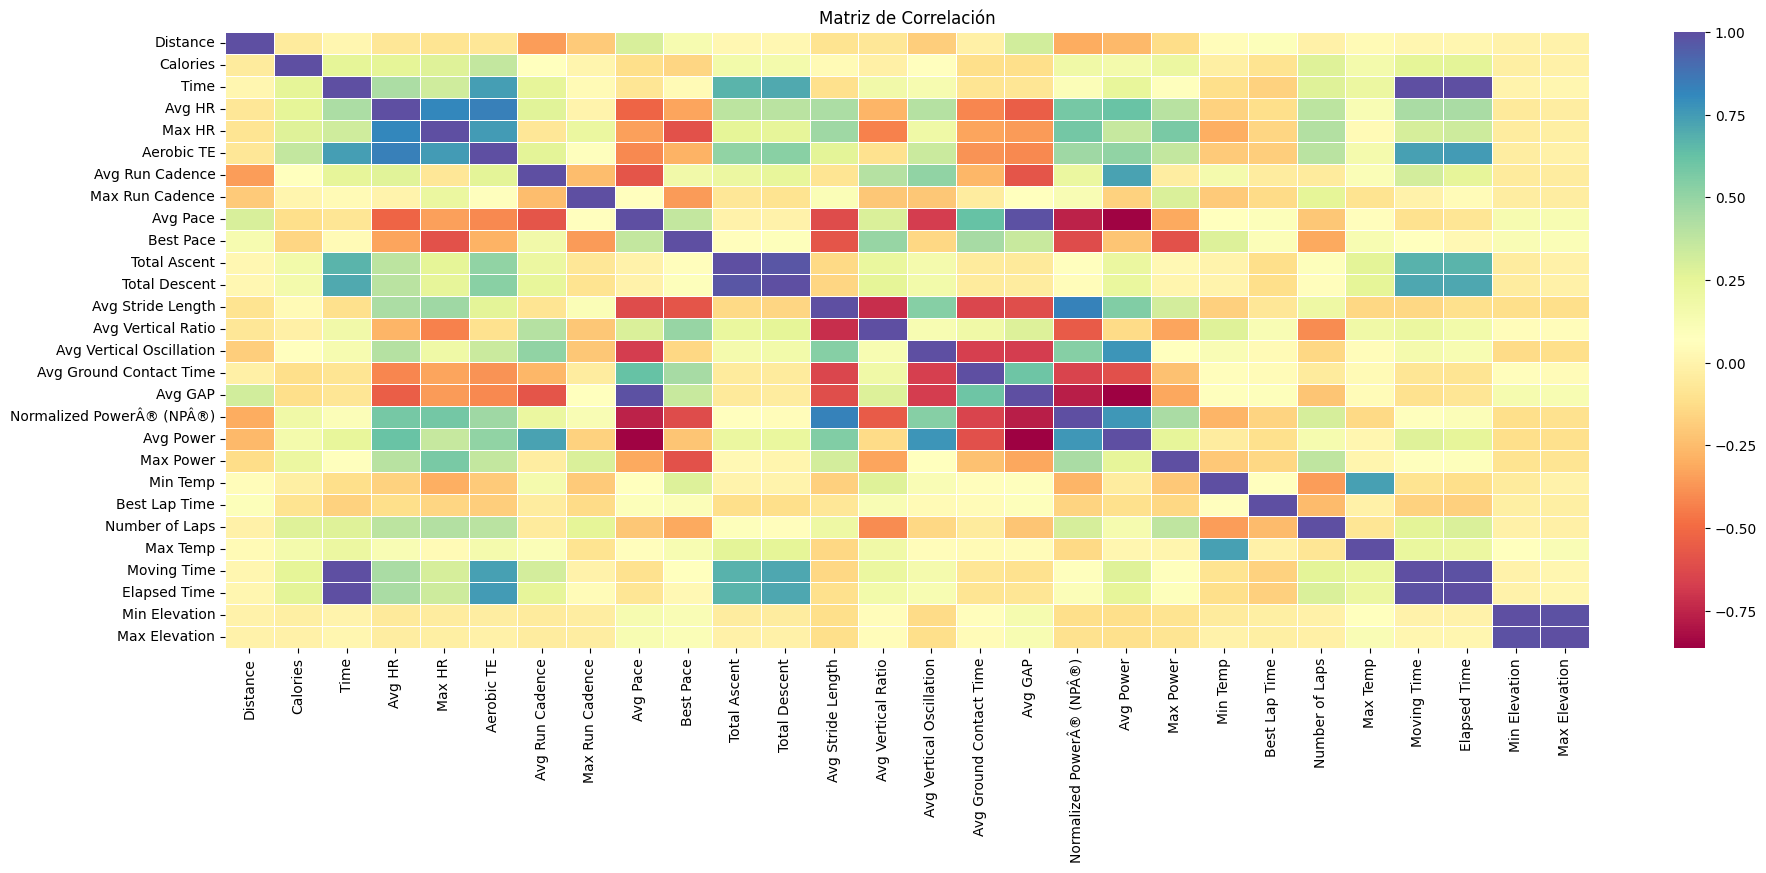

In [20]:
# Seleccionar solo columnas numéricas
numeric_data = data.select_dtypes(include=['number'])

# Calcular la matriz de correlación
corr_matrix = numeric_data.corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(22, 8))
sns.heatmap(corr_matrix, annot=False, cmap='Spectral', linewidths=0.5)
plt.title('Matriz de Correlación')
plt.show()

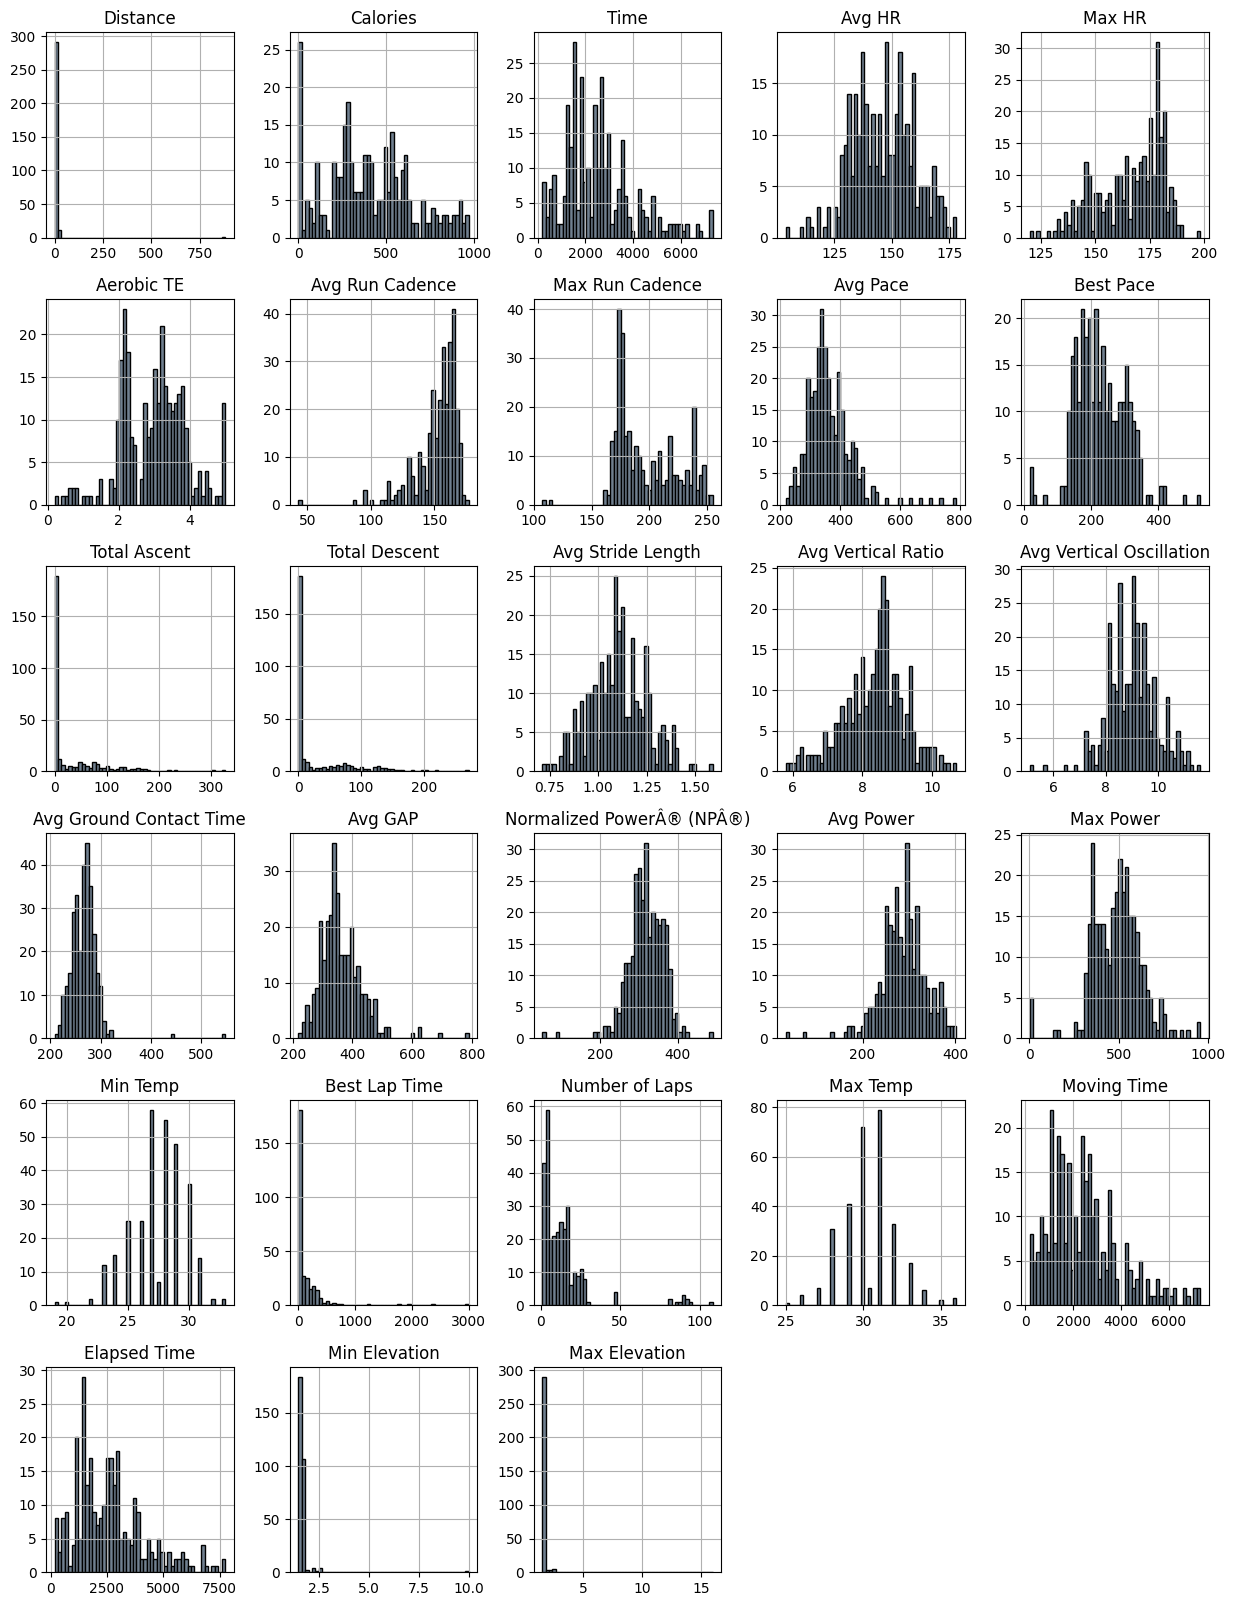

In [21]:
numeric_data.hist(bins=50, figsize=(15, 20), color='slategrey', edgecolor='black')
plt.show()

In [22]:
sorted_benefits = data['Primary Benefit'].value_counts().sort_values(ascending=True)
sorted_benefits

Primary Benefit
No benefit             4
Sprint                 7
Anaerobic Capacity    15
Threshold             29
Vo2 Max               37
Base                  60
Tempo                 70
Recovery              81
Name: count, dtype: int64

Text(0.5, 0, 'Categoría')

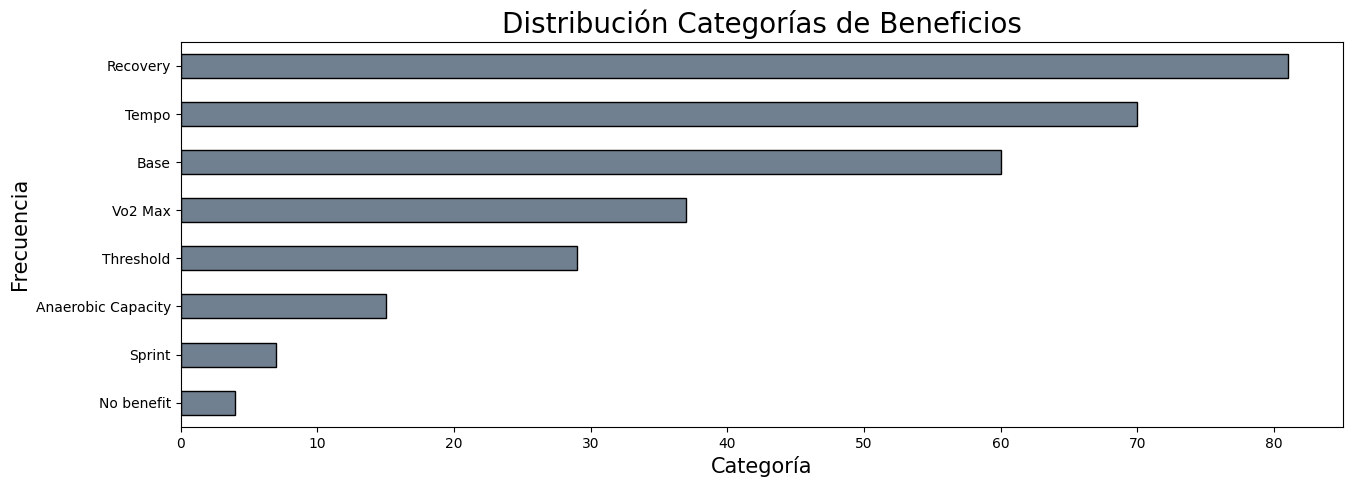

In [23]:
plt.figure(figsize=(15,5))
sorted_benefits.plot(kind='barh', color='slategrey', edgecolor='black' )
plt.title('Distribución Categorías de Beneficios', fontsize=20)
plt.ylabel("Frecuencia", fontsize=15)
plt.xlabel("Categoría", fontsize=15)


In [24]:
le = LabelEncoder()
data_temp = le.fit_transform(data['Primary Benefit'])
data['Primary Benefit'] = data_temp

In [49]:
data, data_test = train_test_split(data, test_size=0.05, random_state=7, stratify=data['Primary Benefit'])

### <CENTER>**CREACIÓN DEL PIPELINE**</CENTER>

In [28]:
scaler = MinMaxScaler()

def model_training(model, data, cross_val=False):

    #Separo la data
    X = data.drop(columns=['Primary Benefit'])
    y = data['Primary Benefit']
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Steps para el pipeline
    steps = [
        ('scaler', scaler),
        ('model', model)
    ]

    # Creo un pipeline temporal
    temp_pipeline = Pipeline(steps)

    if cross_val==True:
        return temp_pipeline, X_train, X_val, y_train, y_val
    else:
        temp_pipeline.fit(X_train, y_train)
        y_pred_train = temp_pipeline.predict(X_train)
        train_accuracy = accuracy_score(y_train, y_pred_train)
        
        y_pred = temp_pipeline.predict(X_val)
        accuracy = accuracy_score(y_val, y_pred) 
        print(f'La precisión del modelo {model} en el conjunto de entrenamiento es {train_accuracy} y en validación es de: {accuracy}')

        return Pipeline(steps), X, y

In [29]:
model_training(RandomForestClassifier(), data)

La precisión del modelo RandomForestClassifier() en el conjunto de entrenamiento es 1.0 y en validación es de: 0.7758620689655172


(Pipeline(steps=[('scaler', MinMaxScaler()),
                 ('model', RandomForestClassifier())]),
      Distance  Calories    Time  Avg HR  Max HR  Aerobic TE  Avg Run Cadence  \
 119     11.03   792.000  3605.0     162     172         4.0              166   
 152      3.33   297.000  1442.0     148     178         2.7              130   
 48       2.00   124.000   625.0     138     148         1.9              161   
 137     12.01   843.000  4265.0     147     160         3.4              162   
 75       3.52   309.000  1835.0     132     162         2.2              113   
 ..        ...       ...     ...     ...     ...         ...              ...   
 255      7.13   540.000  3005.0     140     155         2.9              156   
 193      3.48   279.000  1570.0     134     181         2.3              119   
 138      3.01   197.000  1051.0     138     144         2.1              165   
 268      4.58   362.000  1804.0     141     170         3.1              163   
 142    

### <CENTER> **ENTRENAMIENTO DE MODELOS** </CENTER>

In [30]:
lr = LogisticRegression()
rf = RandomForestClassifier(random_state=26)
knn = KNeighborsClassifier()
svc = SVC()

In [31]:
rf_base, X, y = model_training(rf, data)
lr_base, X, y = model_training(lr, data)
knn_base, X, y = model_training(knn, data)
svc_base, X, y = model_training(svc, data)

La precisión del modelo RandomForestClassifier(random_state=26) en el conjunto de entrenamiento es 1.0 y en validación es de: 0.7586206896551724
La precisión del modelo LogisticRegression() en el conjunto de entrenamiento es 0.6637554585152838 y en validación es de: 0.6724137931034483
La precisión del modelo KNeighborsClassifier() en el conjunto de entrenamiento es 0.6855895196506551 y en validación es de: 0.5517241379310345
La precisión del modelo SVC() en el conjunto de entrenamiento es 0.6812227074235808 y en validación es de: 0.6896551724137931


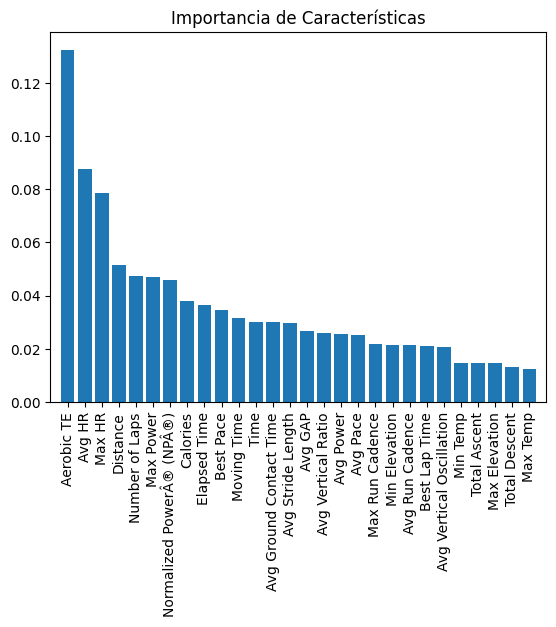

In [32]:
rf_model = rf_base.named_steps['model']
importances = rf_model.feature_importances_
indices = importances.argsort()[::-1]

# Graficar la importancia de las características
plt.figure()
plt.title("Importancia de Características")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

### <CENTER> **OPTIMIZACIÓN DEL MEJOR MODELO** </CENTER>

In [33]:
data_reduced = data.drop(['Max Temp', 'Time', 'Total Ascent', 'Total Descent', 'Avg Vertical Oscillation', 'Best Lap Time', 
                          'Min Temp', 'Max Run Cadence', 'Min Elevation', 'Max Elevation', 'Avg Power'], axis=1)

data_reduced.head()

,Distance,Calories,Avg HR,Max HR,Aerobic TE,Avg Run Cadence,Avg Pace,Best Pace,Avg Stride Length,Avg Vertical Ratio,Avg Ground Contact Time,Avg GAP,Normalized PowerÂ® (NPÂ®),Max Power,Number of Laps,Moving Time,Elapsed Time,Primary Benefit
119,11.03,792.0,162,172,4.0,166,327.0,221.0,1.11,9.1,245,325.0,332,494.0,12,3594.0,3749.0,5
152,3.33,297.0,148,178,2.7,130,433.0,178.0,1.12,8.5,270,433.0,305,541.0,4,1076.0,1442.0,1
48,2.00,124.0,138,148,1.9,161,313.0,326.0,1.07,8.9,260,313.0,293,322.0,2,624.0,625.0,3
137,12.01,843.0,147,160,3.4,162,355.0,257.0,1.05,9.4,265,349.0,328,452.0,13,4256.0,4440.0,1
75,3.52,309.0,132,162,2.2,113,522.0,223.0,1.11,8.6,277,522.0,261,479.0,4,1178.0,1835.0,3


In [34]:
rf_reduced, X, y = model_training(rf, data_reduced)
lr_reduced, X, y = model_training(lr, data_reduced)
knn_reduced, X, y = model_training(knn, data_reduced)
svc_reduced, X, y = model_training(svc, data_reduced)

La precisión del modelo RandomForestClassifier(random_state=26) en el conjunto de entrenamiento es 1.0 y en validación es de: 0.7586206896551724
La precisión del modelo LogisticRegression() en el conjunto de entrenamiento es 0.6506550218340611 y en validación es de: 0.6551724137931034
La precisión del modelo KNeighborsClassifier() en el conjunto de entrenamiento es 0.7030567685589519 y en validación es de: 0.6379310344827587
La precisión del modelo SVC() en el conjunto de entrenamiento es 0.6637554585152838 y en validación es de: 0.6896551724137931


In [35]:
xg = XGBClassifier(device='gpu', verbosity=0)

xg_base, X, y = model_training(xg, data_reduced)

La precisión del modelo XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='gpu', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...) en el conjunto de entrenamiento es 1.0 y en validación es de: 0.7068965517241379


In [36]:
param_grid = {
    'max_depth': [3,4, 5, 6,],
    'n_estimators': [50, 100],
    'learning_rate': [0.1, 0.2, 0.3],
    'colsample_bytree': [0.1, 0.5, 1],
    'reg_lambda': [0, 0.3, 1],
    'gamma': [0, 0.3, 0.5]
}

In [37]:
# Utilizo el parámetro de crossval para extraer el modelo y los datos de entrenamiento estratificados
optimized_model, X_train, X_val, y_train, y_val = model_training(xg, data, cross_val=True)

In [38]:
optimized_model = optimized_model.named_steps['model']

In [39]:
# Manual grid search
best_params = None
best_accuracy = 0

for max_depth in param_grid['max_depth']:
    for n_estimators in param_grid['n_estimators']:
        for learning_rate in param_grid['learning_rate']:
            for colsample_bytree in param_grid['colsample_bytree']:
                for reg_lambda in param_grid['reg_lambda']:
                    for gamma in param_grid['gamma']:

                        params = {
                            'max_depth': max_depth,
                            'n_estimators': n_estimators,
                            'learning_rate': learning_rate,
                            'colsample_bytree': colsample_bytree,
                            'reg_lambda': reg_lambda,
                            'gamma': gamma,
                        }
                        

                        model = optimized_model.set_params(
                            max_depth=params['max_depth'],
                            n_estimators=params['n_estimators'],
                            learning_rate=params['learning_rate'],
                            colsample_bytree=params['colsample_bytree'],
                            reg_lambda=params['reg_lambda'],
                            gamma=params['gamma'],
                            objective='multi:softmax',
                            num_class= len(set(y_train))
                        )
                        model.fit(X_train, y_train)
                        

                        y_pred = model.predict(X_val)
                        val_accuracy = accuracy_score(y_val, y_pred)
                        

                        if val_accuracy > best_accuracy:
                            best_accuracy = val_accuracy
                            best_params = params
                            best_model = model

# Imprimir los resultados
print("\nMejores parámetros:", best_params)
print("Mejor precisión en validación:", best_accuracy)


Mejores parámetros: {'max_depth': 3, 'n_estimators': 50, 'learning_rate': 0.1, 'colsample_bytree': 0.5, 'reg_lambda': 0, 'gamma': 0.3}
Mejor precisión en validación: 0.7931034482758621


In [40]:
best_model.set_params(**best_params)
best_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device='gpu', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.3, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None, num_class=8,
              num_parallel_tree=None, ...)

In [41]:
y_pred_train = best_model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_pred_train)
y_pred = best_model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_pred)

In [42]:
print(f'La precisión del modelo en entrenamiento es: {train_accuracy}, y en validación es: {val_accuracy}')

La precisión del modelo en entrenamiento es: 0.9956331877729258, y en validación es: 0.7931034482758621


Para revisar mejor la precisión del modelo sobre los datos de validación, usaremos LOOCV (Leave One Out Cross Validation)

In [43]:
loo = LeaveOneOut()

# Listas para almacenar errores
accuracy = []

In [44]:
# Realizamos LOOCV
for train_index, val_index in loo.split(data):
    # Dividimos en conjunto de entrenamiento y prueba
    X_train_LOOCV, X_val_LOOCV = X.iloc[train_index], X.iloc[val_index]
    y_train_LOOCV, y_val_LOOCV = y.iloc[train_index], y.iloc[val_index]
    
    # Entrenamos el modelo
    best_model.fit(X_train_LOOCV, y_train_LOOCV)
    
    # Predecimos para el dato de prueba
    y_pred_LOOCV = best_model.predict(X_val_LOOCV)
    
    # Calculamos el error
    precision = accuracy_score(y_val_LOOCV, y_pred_LOOCV)
    accuracy.append(precision)

In [45]:
# Promedio de la precisión
average_precision = np.mean(accuracy)

print(f'La precisión promedio de los modelos en LOOCV es de: {average_precision}')

La precisión promedio de los modelos en LOOCV es de: 0.6933797909407665


Aunque con los datos usados durante LOOCV, el rendimiento sea ligeramente inferior a los resultados anteriores, dada la poca cantidad de datos y el desbalance de clases, es necesario aumentar la cantidad de datos para mejorar la capacidad de generalización del modelo, teniendo en cuenta lo anterior, ahora vamos a hacer predicciones sobre los datos de prueba.

### <CENTER> **RESULTADOS** </CENTER>

In [46]:
best_model.set_params(**best_params)
best_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device='gpu', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.3, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None, num_class=8,
              num_parallel_tree=None, ...)

In [51]:
#Nuevamente reduzco la data al remover columnas con multicolinealidad o datos redundantes
#data_test = data_test.drop(['Max Temp', 'Time', 'Total Ascent', 'Total Descent', 'Avg Vertical Oscillation', 'Best Lap Time', 
#                          'Min Temp', 'Max Run Cadence', 'Min Elevation', 'Max Elevation', 'Avg Power'], axis=1)
X_test = data_test.drop('Primary Benefit', axis=1)
y_test = data_test['Primary Benefit']

In [52]:
#Calculo el error sobre el conjunto de prueba
y_pred_test = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_test)

print(f'La precisión del modelo sobre datos de prueba es de: {test_accuracy}.')

La precisión del modelo sobre datos de prueba es de: 0.9333333333333333.


In [73]:
y_pred_transformed = pd.DataFrame(le.inverse_transform(y_pred_test))
y_real = pd.DataFrame(le.inverse_transform(y_test))

In [76]:
results = pd.concat([y_pred_transformed, y_real], axis=1)
results.columns = ['y_pred', 'y_real']
results

,y_pred,y_real
0,Anaerobic Capacity,Anaerobic Capacity
1,Tempo,Threshold
2,Recovery,Recovery
3,Vo2 Max,Vo2 Max
4,Tempo,Tempo
5,Base,Base
6,Base,Base
7,Tempo,Tempo
8,Recovery,Recovery
9,Tempo,Tempo


In [82]:
y_real.compare(y_pred_transformed, keep_shape=True)

0       
         self  other
0         NaN    NaN
1   Threshold  Tempo
2         NaN    NaN
3         NaN    NaN
4         NaN    NaN
5         NaN    NaN
6         NaN    NaN
7         NaN    NaN
8         NaN    NaN
9         NaN    NaN
10        NaN    NaN
11        NaN    NaN
12        NaN    NaN
13        NaN    NaN
14        NaN    NaN